## DQNで MountainCarを解く

In [1]:
import math
from pathlib import Path

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from rl_mountain_car.dqn import DQNAgent
from rl_mountain_car.utils import render_env
%matplotlib inline

## Config

In [3]:
# 総エピソード数(20とかでもいけるが、運が絡むので一応300としている。
# 100でもたまに上手くいかないときがあるので、うまく行かない場合は、「何度か学習を回す」, 「一番下の学習済みモデルを使用したセルを実行する」などの対処をするとよい。)
EPISODES = 300
# DQNのモデル同期周期
SYNC_INTERVAL = 10
# log出力頻度
LOG_PERIOD = 10
# 学習率
LR = 1e-3
# モデルの重み保存先
MODEL_WEIGHT_DST = Path('./dst/weight.pth')
MODEL_WEIGHT_DST.parent.mkdir(parents=True, exist_ok=True)

## 学習

In [4]:
def energy(state):
    """報酬計算に使用する(https://qiita.com/payanotty/items/07fb38a44cc3bd13e4dd 参考)。
    """
    x = state[0] #位置(横方向)
    g = 0.0025 #重力定数
    v = state[1] #速度

    c = 1 / (g * np.sin(3 * 0.5) + 0.5 * 0.07 * 0.07) #正規化定数

    return c * (g * np.sin(3 * x) + 0.5 * v * v)

In [5]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
agent = DQNAgent(env, epsilon=0.001 + 0.9, lr=LR)
reward_log = []
for episode in range(EPISODES):
    state = env.reset()[0]
    is_done = False
    total_reward = 0
    num_trial = 0
    while not is_done:
        action = agent.get_action(state)
        next_state, _, done, truncated, info = env.step(action)
        is_done = done or truncated
        reward = energy(next_state) - energy(state)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        num_trial += 1
    epsilon = 0.001 + 0.9 / (1.0 + episode)
    agent.set_epsilon(epsilon)
    if episode % SYNC_INTERVAL == 0:
        agent.sync_qnet()
    reward_log.append(total_reward)
    if (episode + 1) % LOG_PERIOD == 0:
        print(f"episode :{episode + 1}, total reward : {total_reward}(num action = {num_trial}, epsilon = {epsilon})")
agent.save_model(MODEL_WEIGHT_DST)

episode :10, total reward : 0.2709798430863837(num action = 200, epsilon = 0.091)
episode :20, total reward : 1.0229355830644482(num action = 200, epsilon = 0.046)
episode :30, total reward : 0.7072598869790704(num action = 200, epsilon = 0.031000000000000003)
episode :40, total reward : 1.2113213596035282(num action = 163, epsilon = 0.0235)
episode :50, total reward : 1.1772325022343213(num action = 185, epsilon = 0.019000000000000003)
episode :60, total reward : 1.2354529336741464(num action = 184, epsilon = 0.016)
episode :70, total reward : 1.2258905883372329(num action = 173, epsilon = 0.013857142857142856)
episode :80, total reward : 1.1745743366780983(num action = 183, epsilon = 0.01225)
episode :90, total reward : 1.1586233935310357(num action = 178, epsilon = 0.011)
episode :100, total reward : 1.194707842534213(num action = 175, epsilon = 0.010000000000000002)
episode :110, total reward : 1.1867519899310943(num action = 172, epsilon = 0.009181818181818183)
episode :120, total

## 報酬のログプロット

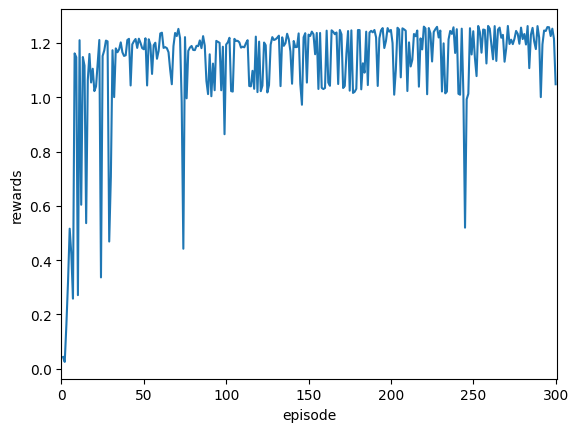

In [6]:
plt.plot(np.arange(1, len(reward_log) + 1), reward_log)
plt.xlim(-0.1, len(reward_log) + 1)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

## 学習したエージェントにてMountainCar-v0を実行

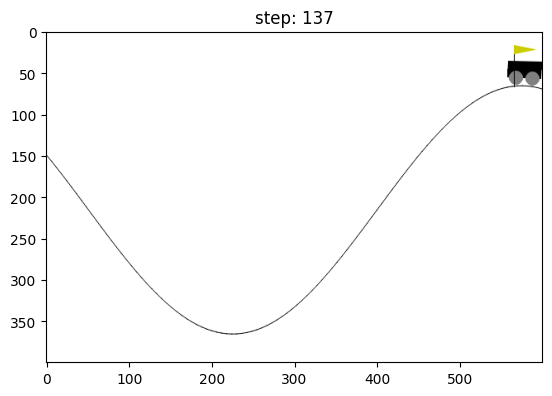

In [7]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state = env.reset(seed=0)[0]
render_period = 10
# 同じ結果を返すようにしたいので、epsilon=0にする。
agent.load_model(MODEL_WEIGHT_DST)
agent.set_epsilon(0)
agent.qnet.eval()
for i in range(200):
    action = agent.get_action(state)
    state, _, done, truncated, info = env.step(action)
    step_title = f'step: {i + 1}'
    if done:
        render_env(env, step_title)
        break
    if ((i + 1) % render_period == 0):
        render_env(env, step_title)
display.clear_output()
env.close()

## 学習済みモデルで動かしたい場合

ゴールに行かない学習が行われるケースがたまにある。

上手くいくケースは下記のセルを実行すると再現できるので、気になる場合は実行。

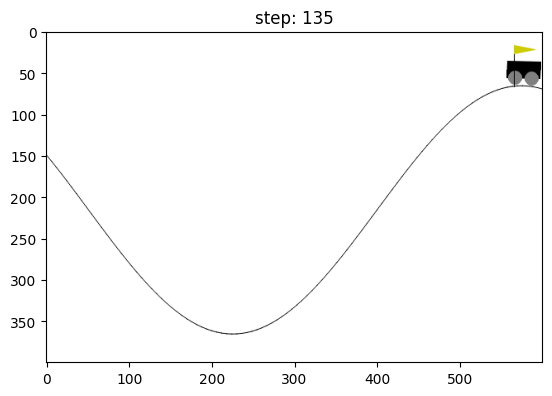

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state = env.reset(seed=0)[0]
render_period = 10
# 同じ結果を返すようにしたいので、epsilon=0にする。
agent = DQNAgent(env)
agent.load_model('./dst/example.pth')
agent.set_epsilon(0)
agent.qnet.eval()
for i in range(200):
    action = agent.get_action(state)
    state, _, done, truncated, info = env.step(action)
    step_title = f'step: {i + 1}'
    if done:
        render_env(env, step_title)
        break
    if ((i + 1) % render_period == 0):
        render_env(env, step_title)
display.clear_output()
env.close()